In [10]:
import os
import mido
import pretty_midi
import random

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.spatial.distance import cosine

from rich.progress import track

In [11]:
plt.style.use("dark_background")
random.seed(1)

USE_BLUR = True

USE_SCALING = True
TARGET_VEL = 80
semitone_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

dataset = os.path.join("..", "inputs", "all-fourbar")
if USE_SCALING:
    input_set = os.path.join("..", "inputs", "all-fourbar")
    dataset = os.path.join("tmp", "dataset")

    if os.path.exists(dataset):
        for file in os.listdir(dataset):
            os.remove(os.path.join(dataset, file))
    else:
        os.mkdir(dataset)

In [12]:
def get_avg_vel(midi_file_path):
    midi = mido.MidiFile(midi_file_path)
    total_velocity = 0
    note_on_count = 0

    for track in midi.tracks:
        for msg in track:
            if msg.type == "note_on" and msg.velocity > 0:
                total_velocity += msg.velocity
                note_on_count += 1

    if note_on_count == 0:
        return 0
    else:
        return total_velocity / note_on_count

In [13]:
def scale_vels(midi_file_path, output_path):
    midi = pretty_midi.PrettyMIDI(midi_file_path)

    avg_vel = get_avg_vel(midi_file_path)
    print(f"avg vel is {avg_vel}")
    scaling_factor = TARGET_VEL / avg_vel

    if scaling_factor < 0.85 or scaling_factor > 1.15:
        # print(
        #     f"\tscale factor s={scaling_factor:03.03f} for avg {avg_vel:03.03f} would be out of valid bounds (0.85, 1.15), skipping"
        # )
        return

    pre_min, pre_max = 128, 1
    post_min, post_max = 128, 1

    for instrument in midi.instruments:
        for note in instrument.notes:
            if note.velocity < pre_min:
                pre_min = note.velocity
            if note.velocity > pre_max:
                pre_max = note.velocity

            new_velocity = int(note.velocity * scaling_factor)
            new_velocity = max(1, min(new_velocity, 127))

            if new_velocity < post_min:
                post_min = new_velocity
            if new_velocity > post_max:
                post_max = new_velocity

            note.velocity = new_velocity
            # note.velocity *= scaling_factor

    midi.write(output_path)
    return output_path

    # print(
    #     f"rescaled (s={scaling_factor:03.03f}) velocity from avg: {avg_vel:03.03f} min: {pre_min:03d} max: {pre_max:03d} -> avg: {get_avg_vel(output_path):03.03f} min: {post_min:03d} max: {post_max:03d}"
    # )

In [14]:
def plot_metric(pr, metric, title) -> None:
    metric_hist, bins = np.histogram(metric, bins=20, range=(0, 340))

    plt.figure(figsize=(12, 6))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.imshow(pr, aspect="auto", origin="lower", cmap="magma")
    plt.title("piano roll")
    plt.xlabel("time (s)")
    plt.ylabel("MIDI note number")

    plt.subplot(1, 2, 2)
    plt.hist(bins[:-1], bins, weights=metric_hist)
    plt.title("energy metric")
    plt.xlabel("energy")
    plt.ylabel("count")

    plt.tight_layout()
    plt.show()

In [15]:
def plot_pr_hists(midi: pretty_midi.PrettyMIDI, energy_hist, title) -> None:
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(2, 2, figure=fig)

    plt.suptitle(title)

    ax1 = fig.add_subplot(gs[:, 0])
    ax1.imshow(midi.get_piano_roll(), aspect="auto", origin="lower", cmap="magma")
    ax1.set_title("First Image")
    # ax1.axis("off")
    ax1.set_title("piano roll")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.bar(
        np.arange(12),
        midi.get_pitch_class_histogram(normalize=False),
        tick_label=semitone_names,
    )
    ax2.set_title("unweighted chromagram")
    ax2.set_xticks([])

    ax3 = fig.add_subplot(gs[1, 1])
    ax3.bar(np.arange(12), energy_hist, tick_label=semitone_names)
    ax3.set_title("energy weighted chromagram")
    # ax3.set_yticks("off")
    ax3.set_xticks(range(12), semitone_names)

    plt.tight_layout()
    plt.show()

In [16]:
def calc_energy_hist(midi_path):
    midi = pretty_midi.PrettyMIDI(midi_path)
    envelope_length = 10  # seconds
    pitch_histogram = {i: 0 for i in range(12)}

    # scale_factor = 1.0
    # if USE_SCALING:
    #     avg_vel = get_avg_vel(midi_path)
    #     scale_factor = TARGET_VEL / avg_vel
    #     print(f"segment has average velocity {avg_vel:.03f} -> scale {scale_factor}")
    #     if scale_factor < 0.85 or scale_factor > 1.15:
    #         print(
    #             f"scale factor would be out of valid bounds (0.85, 1.15), setting to 1.0"
    #         )
    #         scale_factor = 1.0

    for instrument in midi.instruments:
        for note in instrument.notes:
            note_duration = note.end - note.start
            energy = note.velocity * envelope_length / 2

            if note_duration < envelope_length:
                energy = energy - (
                    (envelope_length - note_duration) * note.velocity / 2
                )

            pitch_histogram[note.pitch % 12] += energy

    return pitch_histogram

In [17]:
def calc_energy(midi):
    envelope_length = 10  # seconds
    energies = []
    for instrument in midi.instruments:
        for note in instrument.notes:
            note_duration = note.end - note.start
            energy = note.velocity * envelope_length / 2

            if note_duration < envelope_length:
                energy = energy - (
                    (envelope_length - note_duration) * note.velocity / 2
                )

            # print(f"{note_duration:04.02f}s * {note.velocity} -> {energy:05.02f}")

            energies.append(energy)

    return energies

In [18]:
if USE_SCALING:
    for file in os.listdir(input_set):
        file_path = os.path.join(input_set, file)
        new_file_path = os.path.join(dataset, file)
        scale_vels(file_path, new_file_path)

avg vel is 48.979166666666664
avg vel is 45.55357142857143
avg vel is 55.863247863247864
avg vel is 74.04347826086956
avg vel is 59.736434108527135
avg vel is 73.79591836734694
avg vel is 52.15217391304348
avg vel is 40.37735849056604
avg vel is 65.1063829787234
avg vel is 79.95876288659794
avg vel is 48.333333333333336
avg vel is 70.18
avg vel is 70.92207792207792
avg vel is 76.36879432624113
avg vel is 74.44186046511628
avg vel is 76.07407407407408
avg vel is 66.29113924050633
avg vel is 58.55223880597015
avg vel is 54.891304347826086
avg vel is 59.621212121212125
avg vel is 72.0
avg vel is 65.21875
avg vel is 46.02173913043478
avg vel is 79.56043956043956
avg vel is 45.09090909090909
avg vel is 62.06741573033708
avg vel is 52.78125
avg vel is 82.24444444444444
avg vel is 50.97727272727273
avg vel is 45.4
avg vel is 33.3448275862069
avg vel is 33.47727272727273
avg vel is 82.12605042016807
avg vel is 48.77358490566038
avg vel is 63.46774193548387
avg vel is 73.47747747747748
avg vel 

KeyboardInterrupt: 

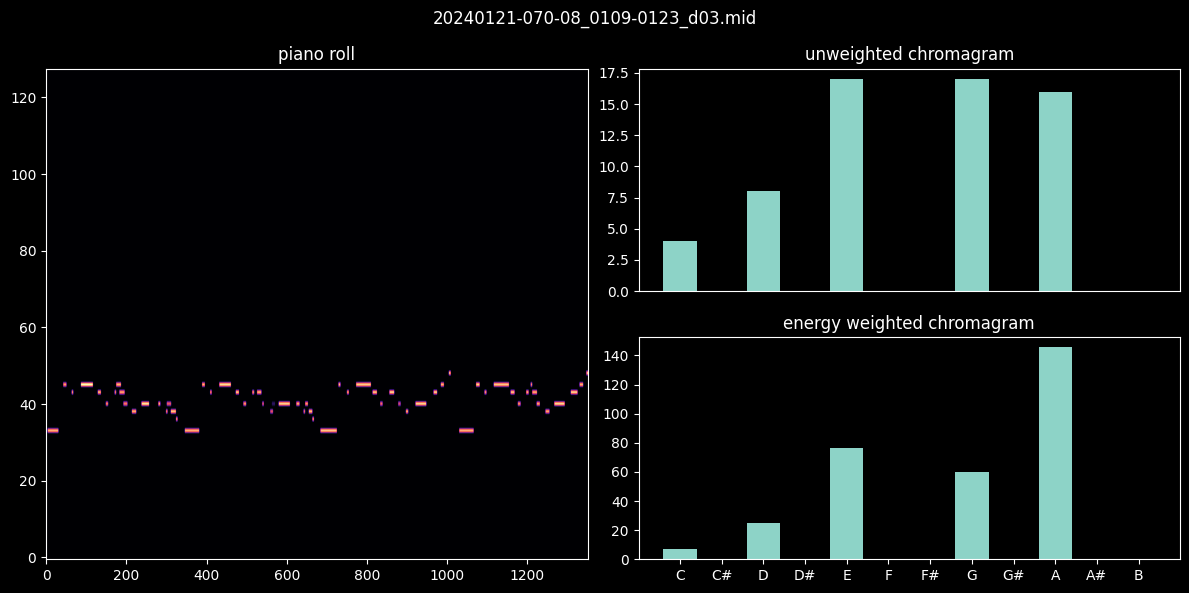

In [10]:
all_files = os.listdir(dataset)
random.shuffle(all_files)

main_file = all_files[0]
main_base_file = main_file.split("_")[0]
main_midi_path = os.path.join(dataset, main_file)
midi_pm = pretty_midi.PrettyMIDI(main_midi_path)
# main_energy = calc_energy(midi_pm)
main_energy_hist = calc_energy_hist(main_midi_path)
main_ph = midi_pm.get_pitch_class_histogram()
# main_energy_hist, _ = np.histogram(main_energy, bins=20, range=(0, 340))

# plot_metric(midi_pm.get_piano_roll(), main_energy, main_file)

plot_pr_hists(midi_pm, main_energy_hist.values(), main_file)

In [11]:
top_ten_cs = [
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
]
for test_midi_file in track(all_files, "calculating similarities..."):
    # for test_midi_file in all_files:
    test_base_file = test_midi_file.split("_")[0]
    if main_base_file == test_base_file:
        continue

    test_midi_path = os.path.join(dataset, test_midi_file)
    midi = pretty_midi.PrettyMIDI(test_midi_path)
    energy_hist = calc_energy_hist(test_midi_path)

    # check cosine distance
    sim_cs = 1 - cosine(list(main_energy_hist.values()), list(energy_hist.values()))
    smallest_value = float("inf")
    smallest_index = None
    for i, (filename, sim) in enumerate(top_ten_cs):
        added_base_files = [afn.split("_")[0] for afn, s in top_ten_cs]
        if (
            sim < sim_cs
            and sim < smallest_value
            and test_base_file not in added_base_files
        ):
            # print(f"replacing {filename.split('_')[0]} with {test_base_file}")
            smallest_value = sim
            smallest_index = i
    if smallest_index is not None:
        top_ten_cs[smallest_index] = [test_midi_file, sim_cs]

Output()

In [12]:
print(top_ten_cs)
new_ttcs = sorted(
    top_ten_cs, key=lambda x: x[1], reverse=True
)  # descending similarities

[['20240227-076-01_0164-0176_d03.mid', 0.9734508579200912], ['20240121-066-01_0145-0159_n00.mid', 0.9755620107082339], ['20240117-064-06_0510-0525_u02.mid', 0.9383566089260722], ['20240227-076-02_0214-0227_d05.mid', 0.9574895592793621], ['20240121-070-09_0027-0041_d03.mid', 0.9645338661805921], ['20231227-080-06_0084-0096_d03.mid', 0.9402755694879787], ['20240123-070-03_1536-1549_u04.mid', 0.9440873535989244], ['20240121-066-03_0232-0247_n00.mid', 0.9590147830403885], ['20231227-080-05_0012-0024_d03.mid', 0.9437547976918101], ['20240216-065-01_0280-0295_u04.mid', 0.9456156652275027]]


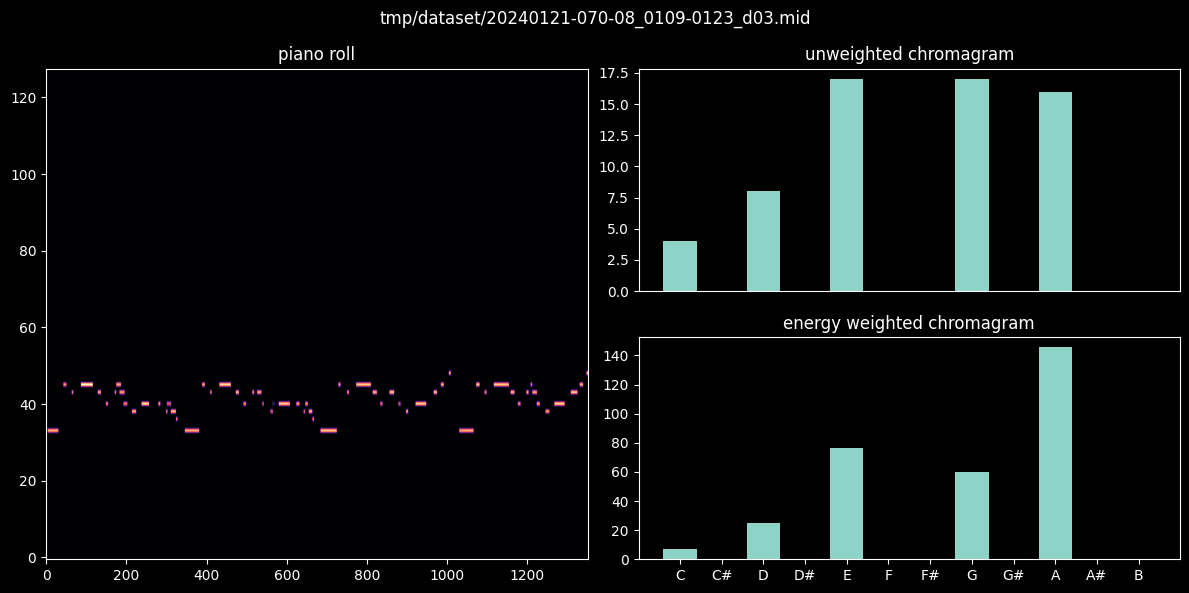

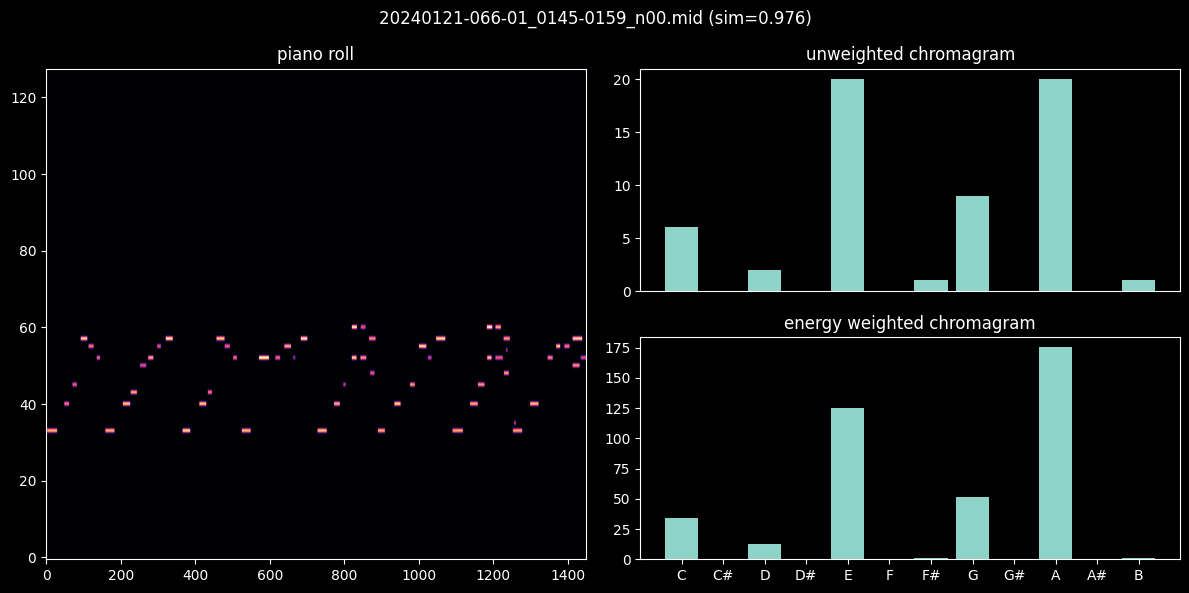

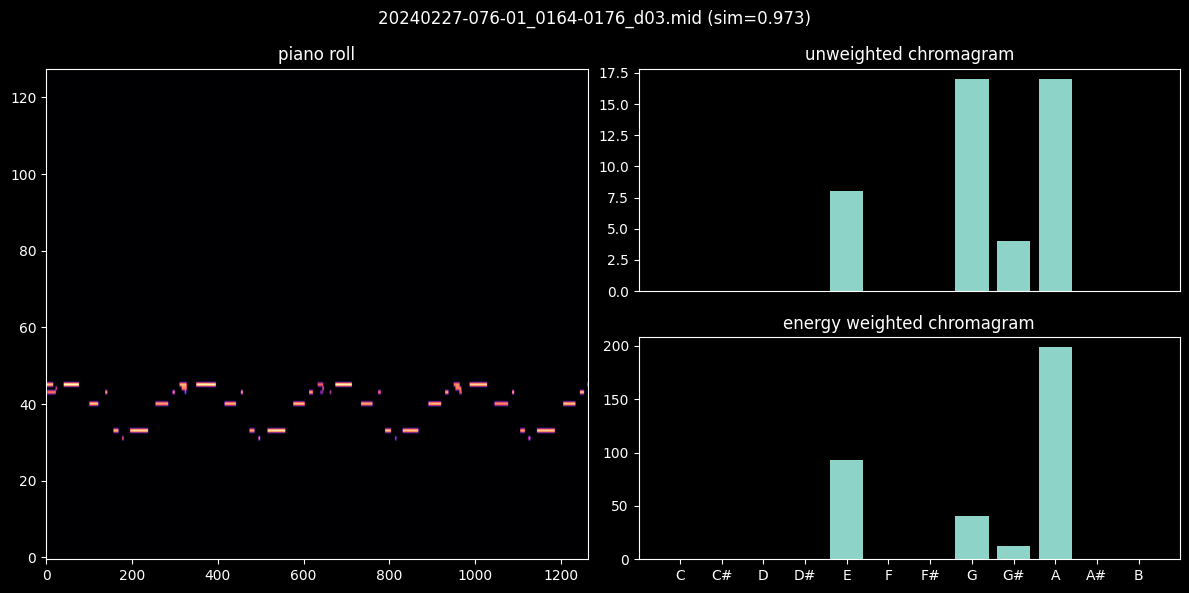

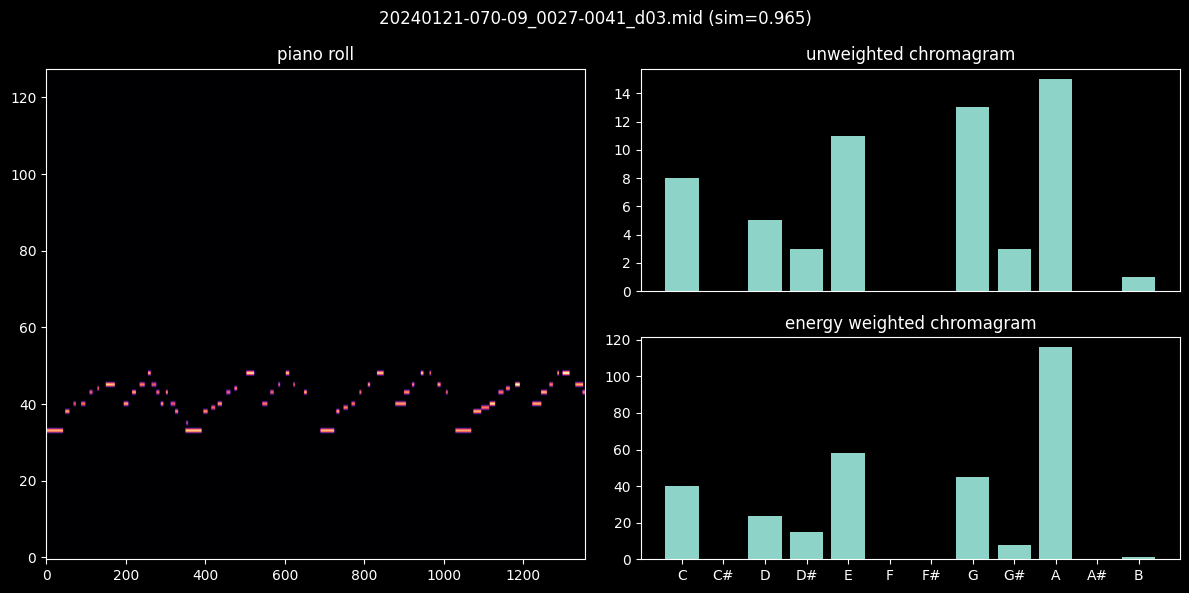

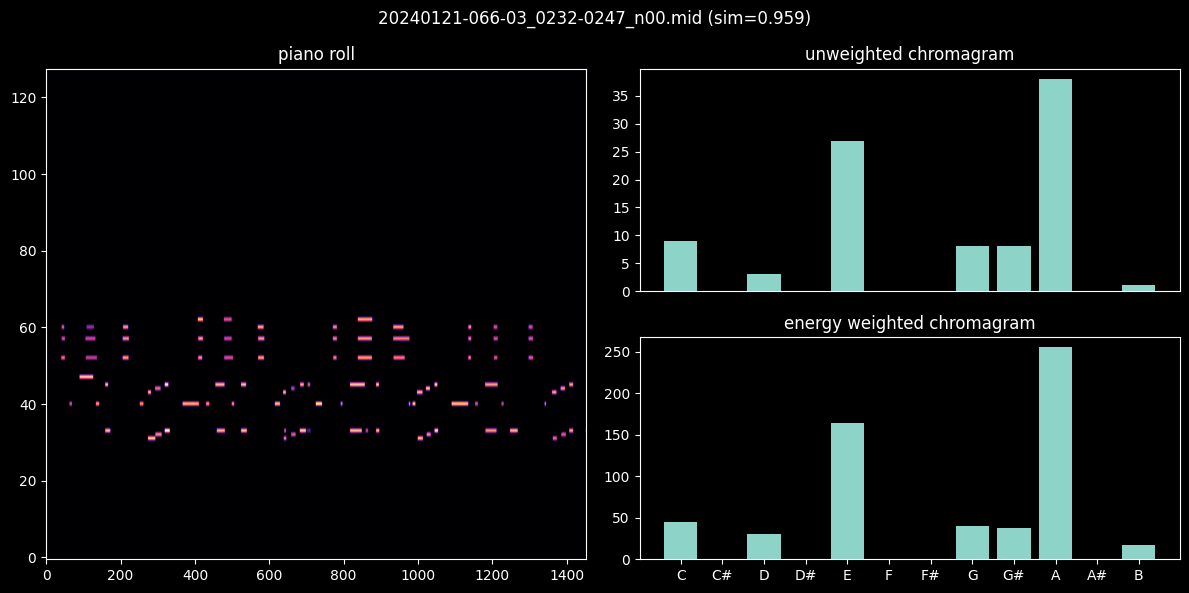

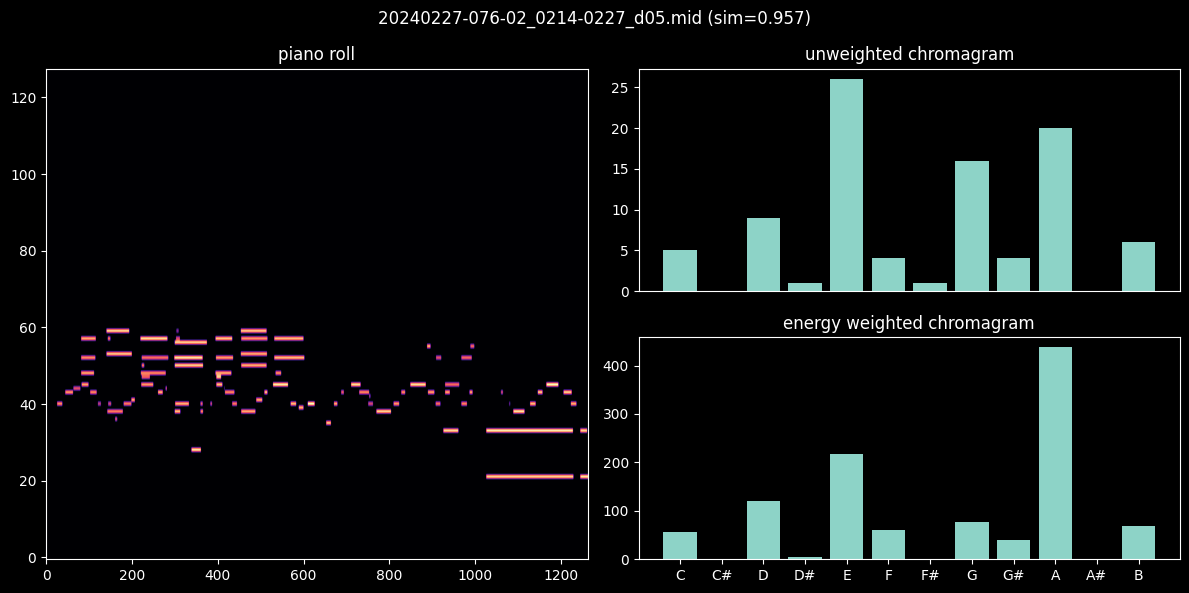

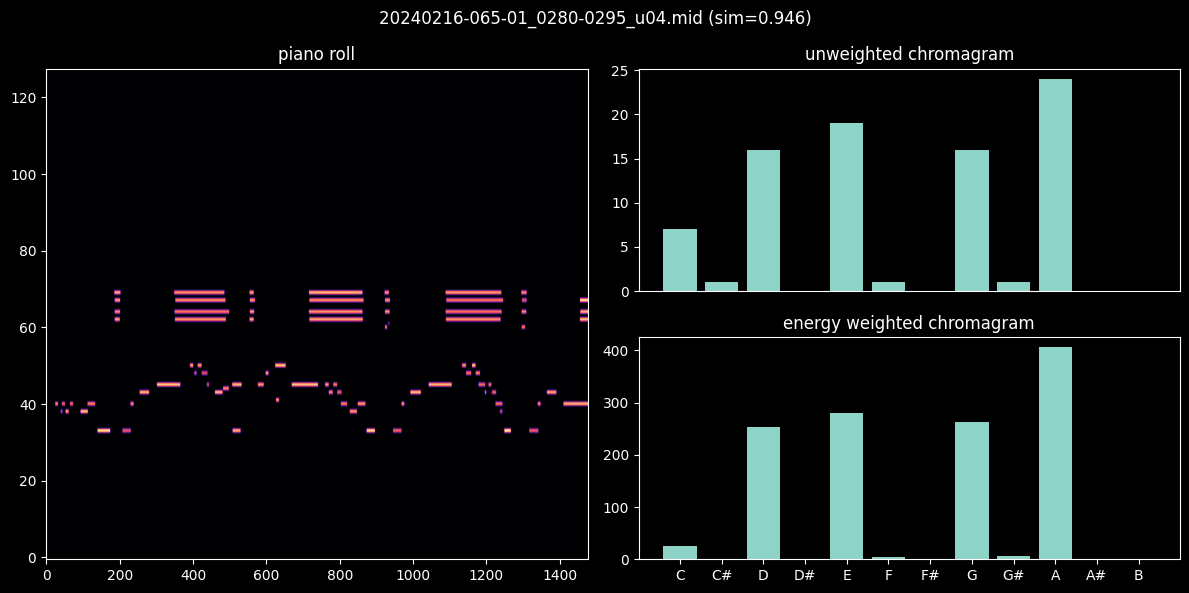

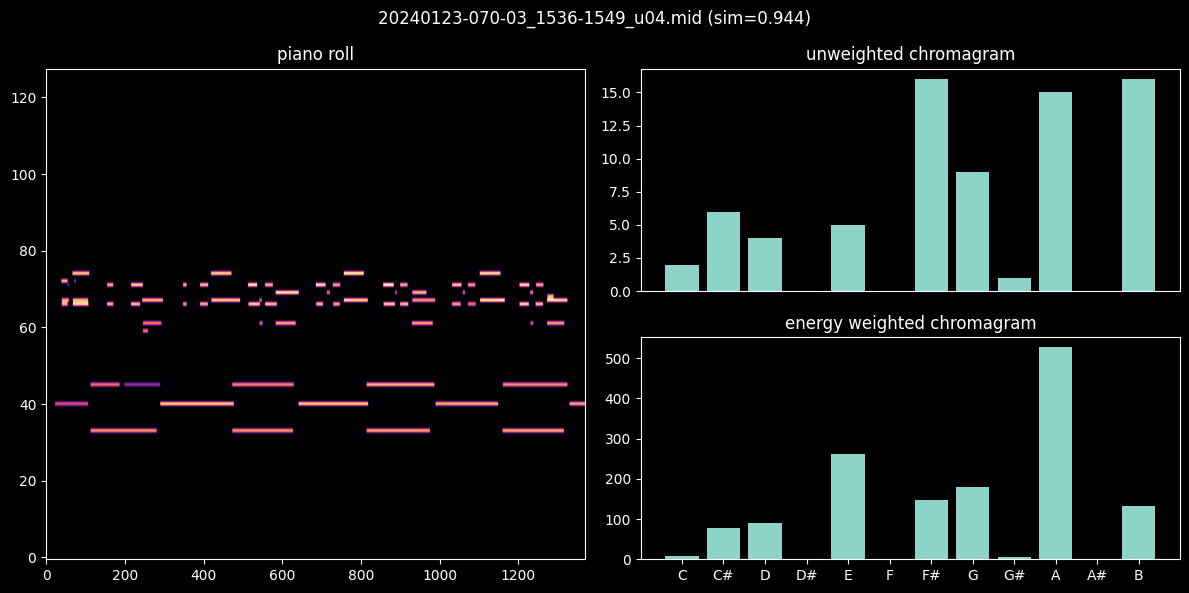

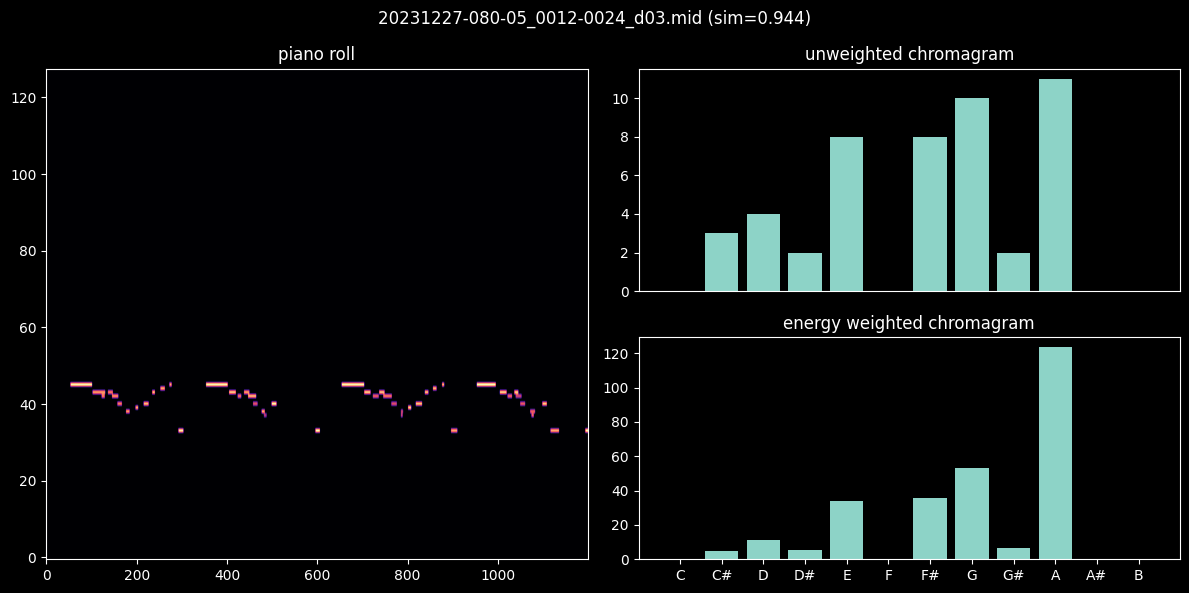

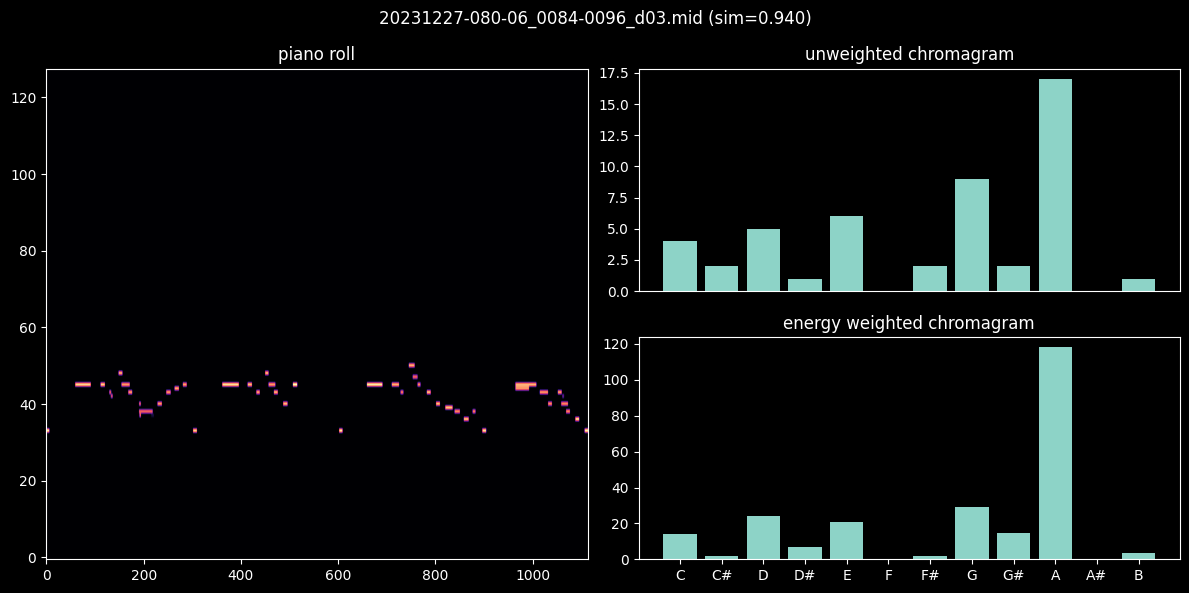

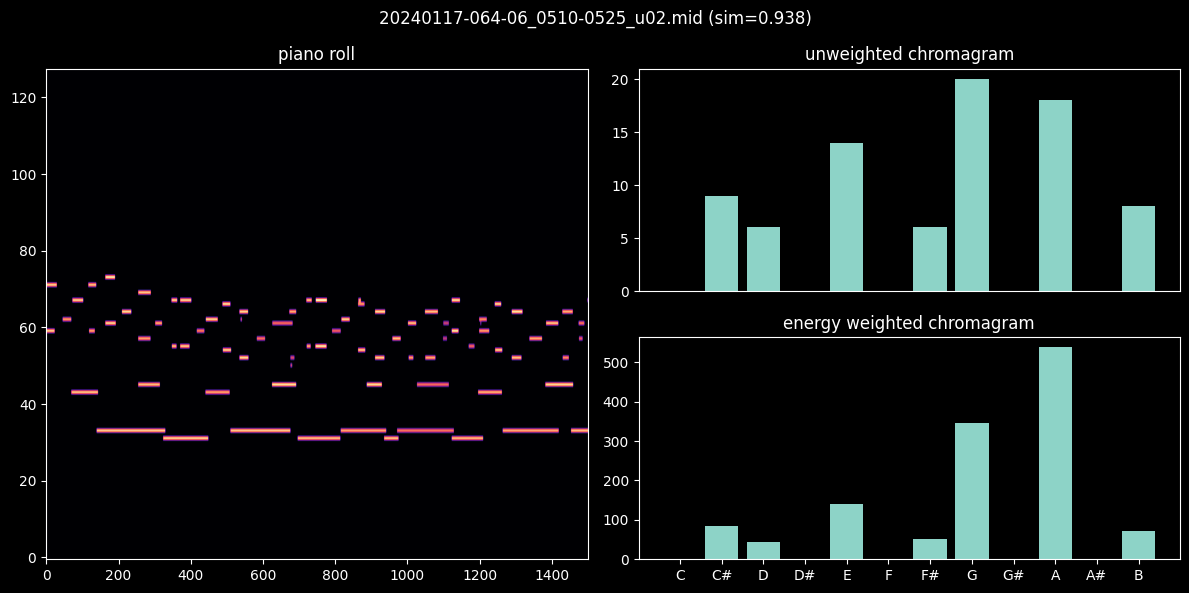

KeyboardInterrupt: 

In [16]:
midi_pm = pretty_midi.PrettyMIDI(main_midi_path)
main_energy_hist = calc_energy_hist(main_midi_path)
plot_pr_hists(midi_pm, list(main_energy_hist.values()), main_midi_path)

with mido.open_output("Disklavier") as output:  # type: ignore
    for message in mido.MidiFile(main_midi_path).play():
        output.send(message)

for file, sim in new_ttcs:
    fp = os.path.join(dataset, file)

    playing_pm = pretty_midi.PrettyMIDI(fp)
    playing_energy = calc_energy_hist(fp)
    plot_pr_hists(playing_pm, list(playing_energy.values()), f"{file} (sim={sim:.03f})")

    with mido.open_output("Disklavier") as output:  # type: ignore
        for message in mido.MidiFile(fp).play():
            output.send(message)